<a href="https://colab.research.google.com/github/ravi-gopalan/singapore_hdb_price_analysis/blob/master/singapore_hdb_resale_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview of the dataset and the purpose

Singapore is a city state and Property ownership is a hallmark of the economy. Land is scarce and the Government encourages all residents to work towards home ownership.

Singapore residents stay in either of private condominia or Housing Development Board (HDB) apartments or bungalows. The largest chunk of the population stay in HDB apartments either as owners or renters. They purchase apartments either when they are newly constructed or resold. Resale of HDB apartments is a strong barometer of the broader Singapore economy. The data of HDB resale transactions have been made available through the Singapore Open Data project https://data.gov.sg/.
Data for HDB resales are available since 1990 organized by each individual transaction including month of transaction, broad location of the property (town and street) as well as type of apartment. The following link has been used to obtain the raw data for analysis https://data.gov.sg/dataset/resale-flat-prices

Data is provided at https://data.gov.sg/dataset/7a339d20-3c57-4b11-a695-9348adfd7614/download
and has 4 csv files zipped together

In [0]:
import requests
import pandas as pd
import numpy as np
import re
import time
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Clone the entire repo.
!git clone -l -s git://github.com/ravi-gopalan/singapore_hdb_price_analysis.git cloned-repo
!cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 381.84 KiB | 1.78 MiB/s, done.
Resolving deltas: 100% (4/4), done.
cloned-repo  sample_data


In [0]:
url = 'https://data.gov.sg/dataset/7a339d20-3c57-4b11-a695-9348adfd7614/download'
file_name = 'resale_flat_prices.zip'
req = requests.get(url)
file = open(file_name, 'wb')
for chunk in req.iter_content(100000):
    file.write(chunk)
file.close()

Data is provided at https://data.gov.sg/dataset/7a339d20-3c57-4b11-a695-9348adfd7614/download and has 5 csv files zipped ogether

In [4]:
!unzip resale_flat_prices.zip

Archive:  resale_flat_prices.zip
 extracting: metadata-resale-flat-prices.txt  
 extracting: resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv  
 extracting: resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv  
 extracting: resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv  
 extracting: resale-flat-prices-based-on-approval-date-2000-feb-2012.csv  
 extracting: resale-flat-prices-based-on-approval-date-1990-1999.csv  


In [0]:
df1 = pd.read_csv('resale-flat-prices-based-on-approval-date-1990-1999.csv')
df2 = pd.read_csv('resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
df3 = pd.read_csv('resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df4 = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df5 = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [6]:
df = pd.concat([df1, df2, df3, df4, df5],axis=0)
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df.head()
df.tail()
df.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804361 entries, 0 to 804360
Data columns (total 11 columns):
block                  804361 non-null object
flat_model             804361 non-null object
flat_type              804361 non-null object
floor_area_sqm         804361 non-null float64
lease_commence_date    804361 non-null int64
month                  804361 non-null object
remaining_lease        95307 non-null object
resale_price           804361 non-null float64
storey_range           804361 non-null object
street_name            804361 non-null object
town                   804361 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 67.5+ MB


In [7]:
df['resale_month'] = pd.to_datetime(df['month'],format='%Y-%m')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804361 entries, 0 to 804360
Data columns (total 12 columns):
block                  804361 non-null object
flat_model             804361 non-null object
flat_type              804361 non-null object
floor_area_sqm         804361 non-null float64
lease_commence_date    804361 non-null int64
month                  804361 non-null object
remaining_lease        95307 non-null object
resale_price           804361 non-null float64
storey_range           804361 non-null object
street_name            804361 non-null object
town                   804361 non-null object
resale_month           804361 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 73.6+ MB


In [8]:
df['flat_model'] = df['flat_model'].str.title()
df.head()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town,resale_month
0,309,Improved,1 ROOM,31.0,1977,1990-01,NaN,9000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01
1,309,Improved,1 ROOM,31.0,1977,1990-01,NaN,6000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01
2,309,Improved,1 ROOM,31.0,1977,1990-01,NaN,8000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01
3,309,Improved,1 ROOM,31.0,1977,1990-01,NaN,6000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01
4,216,New Generation,3 ROOM,73.0,1976,1990-01,NaN,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01


In [9]:
df['flat_type'] = df['flat_type'].str.title()
df['flat_type'].value_counts()
flat_type = {'1 Room': '1R', '2 Room': '2R', '3 Room': '3R', \
             '4 Room': '4R', '5 Room': '5R', 'Executive': 'exec', \
             'Multi Generation': 'multi', 'Multi-Generation': 'multi'}
df['flat_type'] = df['flat_type'].map(flat_type)
df['flat_type'].value_counts()

4R       300061
3R       267262
5R       164900
exec      60954
2R         9423
1R         1265
multi       496
Name: flat_type, dtype: int64

In [10]:
df.isna().sum()

block                       0
flat_model                  0
flat_type                   0
floor_area_sqm              0
lease_commence_date         0
month                       0
remaining_lease        709054
resale_price                0
storey_range                0
street_name                 0
town                        0
resale_month                0
dtype: int64

In [11]:
df['resale_year'] = df['resale_month'].dt.year
df.head()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town,resale_month,resale_year
0,309,Improved,1R,31.0,1977,1990-01,NaN,9000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990
1,309,Improved,1R,31.0,1977,1990-01,NaN,6000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990
2,309,Improved,1R,31.0,1977,1990-01,NaN,8000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990
3,309,Improved,1R,31.0,1977,1990-01,NaN,6000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990
4,216,New Generation,3R,73.0,1976,1990-01,NaN,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990


In [12]:
df.tail()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town,resale_month,resale_year
804356,326,Maisonette,exec,146.0,1988,2019-09,67 years 10 months,543888.0,04 TO 06,YISHUN RING RD,YISHUN,2019-09-01,2019
804357,640A,Apartment,exec,164.0,1992,2019-09,71 years 09 months,695888.0,01 TO 03,YISHUN ST 61,YISHUN,2019-09-01,2019
804358,636A,Apartment,exec,164.0,1992,2019-09,71 years 09 months,745000.0,01 TO 03,YISHUN ST 61,YISHUN,2019-09-01,2019
804359,723,Maisonette,exec,146.0,1986,2019-09,65 years 08 months,605000.0,10 TO 12,YISHUN ST 71,YISHUN,2019-09-01,2019
804360,836,Maisonette,exec,146.0,1988,2019-09,67 years 05 months,640000.0,04 TO 06,YISHUN ST 81,YISHUN,2019-09-01,2019


The data frame has 804,361 observations along 11 variables that cover the apartment sold (i.e. block, street_name, town, storey_range, flat_model, flat_type, floor area in square meters). In addition the data includes the month of the transaction, resale_price as well as year lease commenced and how many years remain on the lease.

It also indicates that apart from the lease commencement and years remaining as integers, and the floor area as numbers all other variables are in character format.

Floor areas for 434 observations (~0.06%) are missing. One may need to analyze the data and see if these could be imputed.
Remaining lease data is missing for ~710k of the observations (~90%). 

We could look to define some of the fields as categories, manipulate column names, standardize some names and also enrich if possible.

The data frame is then manipulated for column names, factors, time fields, enriched values

In [13]:
df['storey_range'].value_counts()

04 TO 06    204464
07 TO 09    184551
01 TO 03    164845
10 TO 12    156218
13 TO 15     50070
16 TO 18     18435
19 TO 21      9019
22 TO 24      5766
01 TO 05      2700
06 TO 10      2474
25 TO 27      2361
11 TO 15      1259
28 TO 30       958
16 TO 20       265
34 TO 36       237
37 TO 39       225
31 TO 33       224
40 TO 42       112
21 TO 25        92
26 TO 30        39
46 TO 48        17
43 TO 45        13
49 TO 51         8
36 TO 40         7
31 TO 35         2
Name: storey_range, dtype: int64

In [14]:
regex_storeys = re.compile(r' TO ', flags=re.IGNORECASE)
df['storey_range'] = df['storey_range'].str.replace(regex_storeys,'-')
df['storey_range'].value_counts()

04-06    204464
07-09    184551
01-03    164845
10-12    156218
13-15     50070
16-18     18435
19-21      9019
22-24      5766
01-05      2700
06-10      2474
25-27      2361
11-15      1259
28-30       958
16-20       265
34-36       237
37-39       225
31-33       224
40-42       112
21-25        92
26-30        39
46-48        17
43-45        13
49-51         8
36-40         7
31-35         2
Name: storey_range, dtype: int64

In [0]:
df_remaining_lease = df['remaining_lease']

In [16]:
df_remaining_lease = df_remaining_lease.str.split(' ',expand=True)
df_remaining_lease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804361 entries, 0 to 804360
Data columns (total 4 columns):
0    58154 non-null object
1    58154 non-null object
2    53527 non-null object
3    53527 non-null object
dtypes: object(4)
memory usage: 24.5+ MB


In [17]:
df_remaining_lease.tail(10)

,0,1,2,3
804351,67,years,09,months
804352,67,years,09,months
804353,68,years,02,months
804354,67,years,10,months
804355,68,years,02,months
804356,67,years,10,months
804357,71,years,09,months
804358,71,years,09,months
804359,65,years,08,months
804360,67,years,05,months


In [18]:
df_remaining_lease.columns = ['first','second','third','fourth']
df_remaining_lease.head()


,first,second,third,fourth
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [20]:
df_remaining_lease.drop(columns=['second','fourth'],inplace=True)
df_remaining_lease['first'].fillna(100000,inplace=True)
df_remaining_lease['third'].fillna(0,inplace=True)
df_remaining_lease = df_remaining_lease.astype({'first': 'int64','third': 'float64' },copy=True)
df_remaining_lease['lease_term_remaining'] = df_remaining_lease['first'] + (df_remaining_lease['third']/12)
df_remaining_lease.head()
df_remaining_lease.info()

,first,third,lease_term_remaining
0,100000,0.0,100000.0
1,100000,0.0,100000.0
2,100000,0.0,100000.0
3,100000,0.0,100000.0
4,100000,0.0,100000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804361 entries, 0 to 804360
Data columns (total 3 columns):
first                   804361 non-null int64
third                   804361 non-null float64
lease_term_remaining    804361 non-null float64
dtypes: float64(2), int64(1)
memory usage: 18.4 MB


In [0]:
df_remaining_lease['lease_term_remaining'] = df_remaining_lease['first'] + (df_remaining_lease['third']/12)

In [22]:
df_remaining_lease['lease_term_remaining'].replace(to_replace= 100000.0,value=0,inplace=True)
df_remaining_lease.drop(columns=['first','third'],inplace=True)
df_remaining_lease.head()
df_remaining_lease.tail()

,lease_term_remaining
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


,lease_term_remaining
804356,67.833333
804357,71.750000
804358,71.750000
804359,65.666667
804360,67.416667


In [23]:
df = pd.concat([df,df_remaining_lease],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804361 entries, 0 to 804360
Data columns (total 14 columns):
block                   804361 non-null object
flat_model              804361 non-null object
flat_type               804361 non-null object
floor_area_sqm          804361 non-null float64
lease_commence_date     804361 non-null int64
month                   804361 non-null object
remaining_lease         95307 non-null object
resale_price            804361 non-null float64
storey_range            804361 non-null object
street_name             804361 non-null object
town                    804361 non-null object
resale_month            804361 non-null datetime64[ns]
resale_year             804361 non-null int64
lease_term_remaining    804361 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(8)
memory usage: 85.9+ MB


In [24]:
df.drop(columns=['remaining_lease'],inplace=True)
df.tail()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,resale_month,resale_year,lease_term_remaining
804356,326,Maisonette,exec,146.0,1988,2019-09,543888.0,04-06,YISHUN RING RD,YISHUN,2019-09-01,2019,67.833333
804357,640A,Apartment,exec,164.0,1992,2019-09,695888.0,01-03,YISHUN ST 61,YISHUN,2019-09-01,2019,71.750000
804358,636A,Apartment,exec,164.0,1992,2019-09,745000.0,01-03,YISHUN ST 61,YISHUN,2019-09-01,2019,71.750000
804359,723,Maisonette,exec,146.0,1986,2019-09,605000.0,10-12,YISHUN ST 71,YISHUN,2019-09-01,2019,65.666667
804360,836,Maisonette,exec,146.0,1988,2019-09,640000.0,04-06,YISHUN ST 81,YISHUN,2019-09-01,2019,67.416667


In [25]:
street_names = pd.DataFrame(df['street_name'].unique())
type(street_names)

pandas.core.frame.DataFrame

In [26]:
street_names.columns=['street_name']
street_names.info()
street_names.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 1 columns):
street_name    559 non-null object
dtypes: object(1)
memory usage: 4.4+ KB


,street_name
0,ANG MO KIO AVE 1
1,ANG MO KIO AVE 3
2,ANG MO KIO AVE 4
3,ANG MO KIO AVE 10
4,ANG MO KIO AVE 5


In [27]:
street_names['updated_street'] = street_names['street_name']+ ';'
street_names.tail()

,street_name,updated_street
554,YISHUN AVE 1,YISHUN AVE 1;
555,ANCHORVALE CRES,ANCHORVALE CRES;
556,ANCHORVALE ST,ANCHORVALE ST;
557,TAMPINES CTRL 8,TAMPINES CTRL 8;
558,YISHUN ST 51,YISHUN ST 51;


In [0]:
regex_street_1 = re.compile(r' ST ', flags=re.IGNORECASE)
regex_street_2 = re.compile(r' ST;', flags=re.IGNORECASE)

regex_road_1 = re.compile(r' RD ', flags=re.IGNORECASE)
regex_road_2 = re.compile(r' RD;', flags=re.IGNORECASE)

regex_lane_1 = re.compile(r' LN ', flags=re.IGNORECASE)
regex_lane_2 = re.compile(r' LN;', flags=re.IGNORECASE)

regex_drive_1 = re.compile(r' DR ', flags=re.IGNORECASE)
regex_drive_2 = re.compile(r' DR;', flags=re.IGNORECASE)

regex_close_1 = re.compile(r' CL ', flags=re.IGNORECASE)
regex_close_2 = re.compile(r' CL;', flags=re.IGNORECASE)

regex_place_1 = re.compile(r' PL ', flags=re.IGNORECASE)
regex_place_2 = re.compile(r' PL;', flags=re.IGNORECASE)

regex_ctrl_1 = re.compile(r' CTRL ', flags=re.IGNORECASE)
regex_ctrl_2 = re.compile(r' CTRL;', flags=re.IGNORECASE)

regex_cres_1 = re.compile(r' CRES ', flags=re.IGNORECASE)
regex_cres_2 = re.compile(r' CRES;', flags=re.IGNORECASE)

regex_terr_1 = re.compile(r' TER ', flags=re.IGNORECASE)
regex_terr_2 = re.compile(r' TER;', flags=re.IGNORECASE)

regex_ave_1 = re.compile(r' AVE ', flags=re.IGNORECASE)
regex_ave_2 = re.compile(r' AVE;', flags=re.IGNORECASE)

regex_nth_1 = re.compile(r' NTH ', flags=re.IGNORECASE)
regex_nth_2 = re.compile(r' NTH;', flags=re.IGNORECASE)
regex_nth_3 = re.compile(r'NTH ', flags=re.IGNORECASE)

regex_sth_1 = re.compile(r' STH ', flags=re.IGNORECASE)
regex_sth_2 = re.compile(r' STH;', flags=re.IGNORECASE)

regex_pk_1 = re.compile(r' PK ', flags=re.IGNORECASE)
regex_pk_2 = re.compile(r' PK;', flags=re.IGNORECASE)

regex_kg_1 = re.compile(r' KG ', flags=re.IGNORECASE)
regex_kg_2 = re.compile(r'KG ', flags=re.IGNORECASE)

regex_tg = re.compile(r'TG ', flags=re.IGNORECASE)

regex_upp = re.compile(r'UPP ', flags=re.IGNORECASE)
regex_lor = re.compile(r'LOR ', flags=re.IGNORECASE)


regex_jln = re.compile(r'JLN ', flags=re.IGNORECASE)

regex_hts = re.compile(r' HTS', flags=re.IGNORECASE)
regex_gdns = re.compile(r' GDNS', flags=re.IGNORECASE)
regex_mkt = re.compile(r' MKT ', flags=re.IGNORECASE)

regex_bt_merah = re.compile(r'BT MERAH', flags=re.IGNORECASE)
regex_bt_batok = re.compile(r'BT BATOK', flags=re.IGNORECASE)
regex_bt_panjang = re.compile(r'BT PANJANG', flags=re.IGNORECASE)
regex_bt_purmei = re.compile(r'BT PURMEI', flags=re.IGNORECASE)
regex_cwealth = re.compile(r"C'WEALTH", flags=re.IGNORECASE)

regex_clean = re.compile(r';', flags=re.IGNORECASE)


In [0]:
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_street_1,' STREET ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_street_2,' STREET')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_road_1,' ROAD ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_road_2,' ROAD')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_lane_1,' LANE ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_lane_2,' LANE')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_drive_1,' DRIVE ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_drive_2,' DRIVE')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_close_1,' CLOSE ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_close_2,' CLOSE')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_place_1,' PLACE ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_place_2,' PLACE')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_ctrl_1,' CENTRAL ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_ctrl_2,' CENTRAL')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_cres_1,' CRESCENT ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_cres_2,' CRESCENT')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_terr_1,' TERRACE ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_terr_2,' TERRACE')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_ave_1,' AVENUE ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_ave_2,' AVENUE')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_nth_1,' NORTH ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_nth_2,' NORTH')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_nth_3,'NORTH ')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_sth_1,' SOUTH ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_sth_2,' SOUTH')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_pk_1,' PARK ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_pk_2,' PARK')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_kg_1,' KAMPONG ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_kg_2,'KAMPONG ')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_tg,'TANJONG ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_upp,'UPPER ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_lor,'LORONG ')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_jln,'JALAN ')



street_names['updated_street'] = street_names['updated_street'].str.replace(regex_hts,' HEIGHTS')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_gdns,' GARDENS')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_mkt,' MARKET ')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_bt_merah,'BUKIT MERAH')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_bt_batok,'BUKIT BATOK')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_bt_panjang,'BUKIT PANJANG')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_bt_purmei,'BUKIT PURMEI')
street_names['updated_street'] = street_names['updated_street'].str.replace(regex_cwealth,'COMMONWEALTH')

street_names['updated_street'] = street_names['updated_street'].str.replace(regex_clean,'')

In [30]:
raw_address = list(street_names['street_name'])
cleaned_address = list(street_names['updated_street']) 

street_dict = {'raw_address':list(street_names['street_name']),
               'cleaned_address':list(street_names['updated_street'])
               }

street_addresses = pd.DataFrame(street_dict)
street_addresses.info()
street_addresses.head()
street_addresses.to_csv('streets_cleaned.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 2 columns):
raw_address        559 non-null object
cleaned_address    559 non-null object
dtypes: object(2)
memory usage: 8.8+ KB


,raw_address,cleaned_address
0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1
1,ANG MO KIO AVE 3,ANG MO KIO AVENUE 3
2,ANG MO KIO AVE 4,ANG MO KIO AVENUE 4
3,ANG MO KIO AVE 10,ANG MO KIO AVENUE 10
4,ANG MO KIO AVE 5,ANG MO KIO AVENUE 5


In [31]:
df = df.merge(street_addresses,'left',left_on='street_name',right_on='raw_address')
df.head()
df.info()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,town,resale_month,resale_year,lease_term_remaining,raw_address,cleaned_address
0,309,Improved,1R,31.0,1977,1990-01,9000.0,10-12,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1
1,309,Improved,1R,31.0,1977,1990-01,6000.0,04-06,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1
2,309,Improved,1R,31.0,1977,1990-01,8000.0,10-12,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1
3,309,Improved,1R,31.0,1977,1990-01,6000.0,07-09,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1
4,216,New Generation,3R,73.0,1976,1990-01,47200.0,04-06,ANG MO KIO AVE 1,ANG MO KIO,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 804361 entries, 0 to 804360
Data columns (total 15 columns):
block                   804361 non-null object
flat_model              804361 non-null object
flat_type               804361 non-null object
floor_area_sqm          804361 non-null float64
lease_commence_date     804361 non-null int64
month                   804361 non-null object
resale_price            804361 non-null float64
storey_range            804361 non-null object
street_name             804361 non-null object
town                    804361 non-null object
resale_month            804361 non-null datetime64[ns]
resale_year             804361 non-null int64
lease_term_remaining    804361 non-null float64
raw_address             804361 non-null object
cleaned_address         804361 non-null object
dtypes: datetime64[ns](1), float64(3), int64(2), object(9)
memory usage: 98.2+ MB


In [0]:
df['full_address'] = df['block'] + ', ' + df['cleaned_address']+ ', ' + df['town'] + ', SINGAPORE'

In [0]:
df_town_address = df[['full_address']]

In [34]:
df_town_address.drop_duplicates(inplace=True)
df_town_address.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9073 entries, 0 to 804306
Data columns (total 1 columns):
full_address    9073 non-null object
dtypes: object(1)
memory usage: 141.8+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
df_town_address.reset_index(drop=True)

,full_address
0,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE"
1,"216, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE"
2,"211, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE"
3,"202, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE"
4,"235, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE"
5,"232, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE"
6,"308, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE"
7,"220, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE"
8,"219, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE"
9,"247, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE"


In [36]:
df_lat_long = pd.read_csv('cloned-repo/sing_geo_codes.csv')
df_lat_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 4 columns):
full_address    9331 non-null object
town            9331 non-null object
lat             9331 non-null float64
lon             9331 non-null float64
dtypes: float64(2), object(2)
memory usage: 291.7+ KB


In [37]:
df_lat_long.head()

,full_address,town,lat,lon
0,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
1,"216, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
2,"211, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE",ANG MO KIO,1.369204,103.843949
3,"202, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE",ANG MO KIO,1.368467,103.844154
4,"235, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE",ANG MO KIO,1.369204,103.843949


In [38]:
df_geo = df_town_address.merge(df_lat_long,'left',on='full_address')
df_geo.head()
df_geo.tail()

,full_address,town,lat,lon
0,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
1,"216, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
2,"211, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE",ANG MO KIO,1.369204,103.843949
3,"202, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE",ANG MO KIO,1.368467,103.844154
4,"235, ANG MO KIO AVENUE 3, ANG MO KIO, SINGAPORE",ANG MO KIO,1.369204,103.843949


,full_address,town,lat,lon
9068,"523D, TAMPINES CENTRAL 7, TAMPINES, SINGAPORE",TAMPINES,1.358895,103.941117
9069,"180B, MARSILING ROAD, WOODLANDS, SINGAPORE",WOODLANDS,1.439082,103.778386
9070,"335B, YISHUN STREET 31, YISHUN, SINGAPORE",YISHUN,1.432869,103.844335
9071,"333C, YISHUN STREET 31, YISHUN, SINGAPORE",YISHUN,1.431896,103.845796
9072,"504A, YISHUN STREET 51, YISHUN, SINGAPORE",YISHUN,1.422699,103.836717


In [39]:
unmapped_addresses = list(df_geo[df_geo.isna().any(axis=1)]['full_address'])
unmapped_addresses

[]

In [40]:
geolocator = Nominatim(user_agent="sing_analysis")
geo_matched_details = []
unmatched_addresses = []
count_total = 0
count_unmatched = 0

for address in unmapped_addresses:
  count_total +=1
  try:
    location = geolocator.geocode(address)
    geo_matched_details.append(location.raw)
  except:
    unmatched_addresses.append(address)
    count_unmatched +=1
    print('{} unmatched out of {}'.format(count_unmatched, count_total))
  

  time.sleep(0.5)
print('done')

done


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804361 entries, 0 to 804360
Data columns (total 16 columns):
block                   804361 non-null object
flat_model              804361 non-null object
flat_type               804361 non-null object
floor_area_sqm          804361 non-null float64
lease_commence_date     804361 non-null int64
month                   804361 non-null object
resale_price            804361 non-null float64
storey_range            804361 non-null object
street_name             804361 non-null object
town                    804361 non-null object
resale_month            804361 non-null datetime64[ns]
resale_year             804361 non-null int64
lease_term_remaining    804361 non-null float64
raw_address             804361 non-null object
cleaned_address         804361 non-null object
full_address            804361 non-null object
dtypes: datetime64[ns](1), float64(3), int64(2), object(10)
memory usage: 104.3+ MB


In [42]:
df.drop(columns=['town'],inplace=True)
df = df.merge(df_geo,how='left',on='full_address')
df.head()
df.tail()


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,resale_month,resale_year,lease_term_remaining,raw_address,cleaned_address,full_address,town,lat,lon
0,309,Improved,1R,31.0,1977,1990-01,9000.0,10-12,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
1,309,Improved,1R,31.0,1977,1990-01,6000.0,04-06,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
2,309,Improved,1R,31.0,1977,1990-01,8000.0,10-12,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
3,309,Improved,1R,31.0,1977,1990-01,6000.0,07-09,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977
4,216,New Generation,3R,73.0,1976,1990-01,47200.0,04-06,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"216, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,resale_month,resale_year,lease_term_remaining,raw_address,cleaned_address,full_address,town,lat,lon
804356,326,Maisonette,exec,146.0,1988,2019-09,543888.0,04-06,YISHUN RING RD,2019-09-01,2019,67.833333,YISHUN RING RD,YISHUN RING ROAD,"326, YISHUN RING ROAD, YISHUN, SINGAPORE",YISHUN,1.430988,103.844461
804357,640A,Apartment,exec,164.0,1992,2019-09,695888.0,01-03,YISHUN ST 61,2019-09-01,2019,71.750000,YISHUN ST 61,YISHUN STREET 61,"640A, YISHUN STREET 61, YISHUN, SINGAPORE",YISHUN,1.422699,103.836717
804358,636A,Apartment,exec,164.0,1992,2019-09,745000.0,01-03,YISHUN ST 61,2019-09-01,2019,71.750000,YISHUN ST 61,YISHUN STREET 61,"636A, YISHUN STREET 61, YISHUN, SINGAPORE",YISHUN,1.422699,103.836717
804359,723,Maisonette,exec,146.0,1986,2019-09,605000.0,10-12,YISHUN ST 71,2019-09-01,2019,65.666667,YISHUN ST 71,YISHUN STREET 71,"723, YISHUN STREET 71, YISHUN, SINGAPORE",YISHUN,1.426074,103.829919
804360,836,Maisonette,exec,146.0,1988,2019-09,640000.0,04-06,YISHUN ST 81,2019-09-01,2019,67.416667,YISHUN ST 81,YISHUN STREET 81,"836, YISHUN STREET 81, YISHUN, SINGAPORE",YISHUN,1.411921,103.834687


In [43]:
town_region_map = {\
                   'ANG MO KIO':'NorthEast','BEDOK':'East','BISHAN':'NorthEast',\
                   'BUKIT BATOK':'West','BUKIT MERAH':'Central','BUKIT PANJANG':'West',\
                   'BUKIT TIMAH':'Central','CENTRAL AREA':'Central','CHOA CHU KANG':'West',\
                   'CLEMENTI':'Central','GEYLANG':'Central','HOUGANG':'NorthEast',\
                   'JURONG EAST':'West','JURONG WEST':'West','KALLANG/WHAMPOA':'Central',\
                   'LIM CHU KANG':'West','MARINE PARADE':'Central','PASIR RIS':'East',\
                   'PUNGGOL':'NorthEast','QUEENSTOWN':'Central','SEMBAWANG':'North',\
                   'SENGKANG':'NorthEast','SERANGOON':'Central','TAMPINES':'East',\
                   'TOA PAYOH':'Central','WOODLANDS':'North','YISHUN':'North'\
                   }

df['region'] = df['town'].map(town_region_map)
df['region'].value_counts()

Central      193345
West         177026
East         161181
NorthEast    143614
North        129195
Name: region, dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804361 entries, 0 to 804360
Data columns (total 19 columns):
block                   804361 non-null object
flat_model              804361 non-null object
flat_type               804361 non-null object
floor_area_sqm          804361 non-null float64
lease_commence_date     804361 non-null int64
month                   804361 non-null object
resale_price            804361 non-null float64
storey_range            804361 non-null object
street_name             804361 non-null object
resale_month            804361 non-null datetime64[ns]
resale_year             804361 non-null int64
lease_term_remaining    804361 non-null float64
raw_address             804361 non-null object
cleaned_address         804361 non-null object
full_address            804361 non-null object
town                    804361 non-null object
lat                     804361 non-null float64
lon                     804361 non-null float64
region                  804361 n

In [45]:
df_5_year_interval = pd.cut(df['resale_year'],np.arange(1989,2020,5))
df_10_year_interval = pd.cut(df['resale_year'],np.arange(1989,2020,10))
df_5_year_interval = df_5_year_interval.rename('resale_5yr')
df_10_year_interval = df_10_year_interval.rename('resale_10yr')
df_5_year_interval.name,df_10_year_interval.name 

('resale_5yr', 'resale_10yr')

In [46]:
df = pd.concat([df,df_5_year_interval,df_10_year_interval],axis=1)
df.info()
df.head()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804361 entries, 0 to 804360
Data columns (total 21 columns):
block                   804361 non-null object
flat_model              804361 non-null object
flat_type               804361 non-null object
floor_area_sqm          804361 non-null float64
lease_commence_date     804361 non-null int64
month                   804361 non-null object
resale_price            804361 non-null float64
storey_range            804361 non-null object
street_name             804361 non-null object
resale_month            804361 non-null datetime64[ns]
resale_year             804361 non-null int64
lease_term_remaining    804361 non-null float64
raw_address             804361 non-null object
cleaned_address         804361 non-null object
full_address            804361 non-null object
town                    804361 non-null object
lat                     804361 non-null float64
lon                     804361 non-null float64
region                  804361 n

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,resale_month,resale_year,lease_term_remaining,raw_address,cleaned_address,full_address,town,lat,lon,region,resale_5yr,resale_10yr
0,309,Improved,1R,31.0,1977,1990-01,9000.0,10-12,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977,NorthEast,"(1989, 1994]","(1989, 1999]"
1,309,Improved,1R,31.0,1977,1990-01,6000.0,04-06,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977,NorthEast,"(1989, 1994]","(1989, 1999]"
2,309,Improved,1R,31.0,1977,1990-01,8000.0,10-12,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977,NorthEast,"(1989, 1994]","(1989, 1999]"
3,309,Improved,1R,31.0,1977,1990-01,6000.0,07-09,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"309, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977,NorthEast,"(1989, 1994]","(1989, 1999]"
4,216,New Generation,3R,73.0,1976,1990-01,47200.0,04-06,ANG MO KIO AVE 1,1990-01-01,1990,0.0,ANG MO KIO AVE 1,ANG MO KIO AVENUE 1,"216, ANG MO KIO AVENUE 1, ANG MO KIO, SINGAPORE",ANG MO KIO,1.365305,103.838977,NorthEast,"(1989, 1994]","(1989, 1999]"


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,storey_range,street_name,resale_month,resale_year,lease_term_remaining,raw_address,cleaned_address,full_address,town,lat,lon,region,resale_5yr,resale_10yr
804356,326,Maisonette,exec,146.0,1988,2019-09,543888.0,04-06,YISHUN RING RD,2019-09-01,2019,67.833333,YISHUN RING RD,YISHUN RING ROAD,"326, YISHUN RING ROAD, YISHUN, SINGAPORE",YISHUN,1.430988,103.844461,North,"(2014, 2019]","(2009, 2019]"
804357,640A,Apartment,exec,164.0,1992,2019-09,695888.0,01-03,YISHUN ST 61,2019-09-01,2019,71.750000,YISHUN ST 61,YISHUN STREET 61,"640A, YISHUN STREET 61, YISHUN, SINGAPORE",YISHUN,1.422699,103.836717,North,"(2014, 2019]","(2009, 2019]"
804358,636A,Apartment,exec,164.0,1992,2019-09,745000.0,01-03,YISHUN ST 61,2019-09-01,2019,71.750000,YISHUN ST 61,YISHUN STREET 61,"636A, YISHUN STREET 61, YISHUN, SINGAPORE",YISHUN,1.422699,103.836717,North,"(2014, 2019]","(2009, 2019]"
804359,723,Maisonette,exec,146.0,1986,2019-09,605000.0,10-12,YISHUN ST 71,2019-09-01,2019,65.666667,YISHUN ST 71,YISHUN STREET 71,"723, YISHUN STREET 71, YISHUN, SINGAPORE",YISHUN,1.426074,103.829919,North,"(2014, 2019]","(2009, 2019]"
804360,836,Maisonette,exec,146.0,1988,2019-09,640000.0,04-06,YISHUN ST 81,2019-09-01,2019,67.416667,YISHUN ST 81,YISHUN STREET 81,"836, YISHUN STREET 81, YISHUN, SINGAPORE",YISHUN,1.411921,103.834687,North,"(2014, 2019]","(2009, 2019]"


In [0]:
df['psm'] = df['resale_price']/df['floor_area_sqm']

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


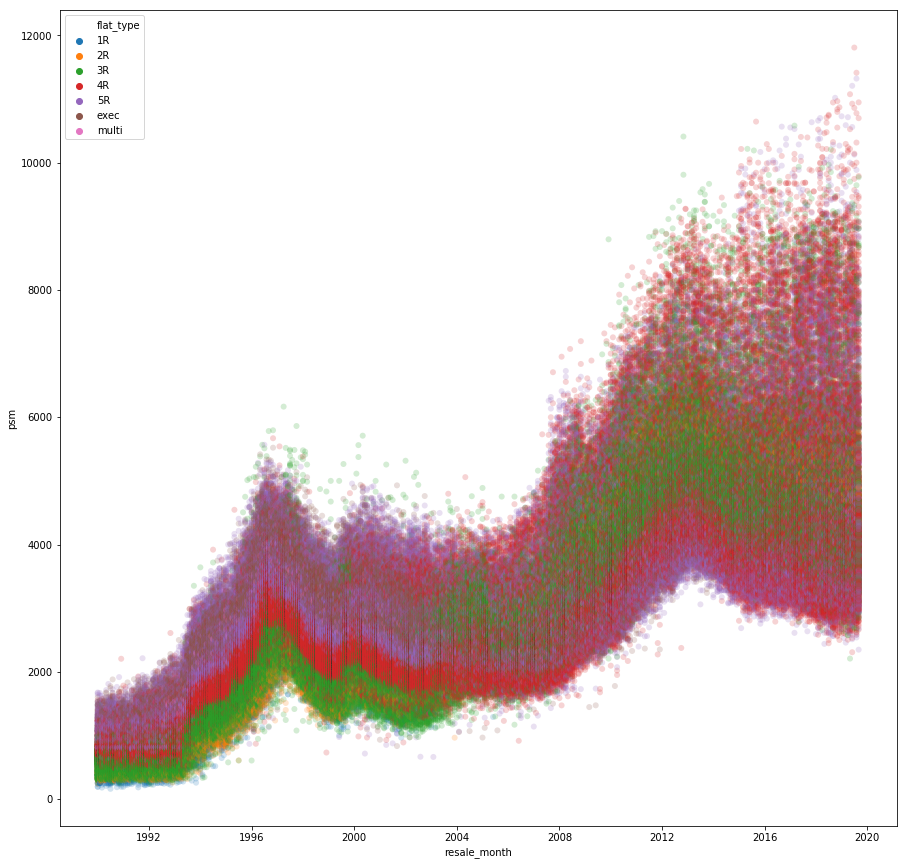

In [48]:
flat_ranking = ['1R', '2R', '3R', '4R', '5R', 'exec', 'multi']

f, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x='resale_month', y='psm', data=df,
                hue='flat_type', hue_order=flat_ranking,
                linewidth=0,
                ax=ax,alpha=0.2)

In [49]:
df.isnull().sum()

block                   0
flat_model              0
flat_type               0
floor_area_sqm          0
lease_commence_date     0
month                   0
resale_price            0
storey_range            0
street_name             0
resale_month            0
resale_year             0
lease_term_remaining    0
raw_address             0
cleaned_address         0
full_address            0
town                    0
lat                     0
lon                     0
region                  0
resale_5yr              0
resale_10yr             0
psm                     0
dtype: int64

In [50]:
df_simplified = df[['region','town','flat_type','flat_model','storey_range','resale_10yr','resale_5yr','resale_year','resale_month','resale_price','floor_area_sqm']]
df_simplified.head()

,region,town,flat_type,flat_model,storey_range,resale_10yr,resale_5yr,resale_year,resale_month,resale_price,floor_area_sqm
0,NorthEast,ANG MO KIO,1R,Improved,10-12,"(1989, 1999]","(1989, 1994]",1990,1990-01-01,9000.0,31.0
1,NorthEast,ANG MO KIO,1R,Improved,04-06,"(1989, 1999]","(1989, 1994]",1990,1990-01-01,6000.0,31.0
2,NorthEast,ANG MO KIO,1R,Improved,10-12,"(1989, 1999]","(1989, 1994]",1990,1990-01-01,8000.0,31.0
3,NorthEast,ANG MO KIO,1R,Improved,07-09,"(1989, 1999]","(1989, 1994]",1990,1990-01-01,6000.0,31.0
4,NorthEast,ANG MO KIO,3R,New Generation,04-06,"(1989, 1999]","(1989, 1994]",1990,1990-01-01,47200.0,73.0


In [0]:
df_grouped = df_simplified.groupby(by=['region','town','flat_type','flat_model','resale_10yr','resale_5yr','resale_year','resale_month'],\
                                   as_index=False)\
                                   .agg({'resale_price': ['sum', 'count','mean','median'], \
                                         'floor_area_sqm': ['sum','count','mean','median']})


In [57]:
df_grouped.head()
df_grouped.tail()

region         town flat_type  ... floor_area_sqm                  
                                   ...          count       mean median
0  Central  BUKIT MERAH        1R  ...              5  29.800000   29.0
1  Central  BUKIT MERAH        1R  ...             10  28.900000   29.0
2  Central  BUKIT MERAH        1R  ...              3  29.666667   29.0
3  Central  BUKIT MERAH        1R  ...              5  29.400000   29.0
4  Central  BUKIT MERAH        1R  ...              3  29.666667   29.0

[5 rows x 16 columns]

region          town flat_type  ... floor_area_sqm             
                                      ...          count  mean median
85237   West  LIM CHU KANG        4R  ...              1  83.0   83.0
85238   West  LIM CHU KANG        4R  ...              1  83.0   83.0
85239   West  LIM CHU KANG        4R  ...              1  83.0   83.0
85240   West  LIM CHU KANG        4R  ...              1  83.0   83.0
85241   West  LIM CHU KANG        4R  ...              1  83.0   83.0

[5 rows x 16 columns]

In [0]:
df_grouped_2 = df_simplified.groupby(by=['region','town','flat_type','flat_model','resale_10yr','resale_5yr','resale_year','resale_month'],\
                                   as_index=False)\
                                   .agg({'resale_price': ['sum','count','mean','median'],\
                                         'floor_area_sqm': ['sum','count','mean','median']
                                         })

In [76]:
df_grouped_2.head()

region         town flat_type  ... resale_price                     
                                   ...        count         mean  median
0  Central  BUKIT MERAH        1R  ...            5  8080.000000  7300.0
1  Central  BUKIT MERAH        1R  ...           10  7680.000000  7300.0
2  Central  BUKIT MERAH        1R  ...            3  8166.666667  7300.0
3  Central  BUKIT MERAH        1R  ...            5  8580.000000  9200.0
4  Central  BUKIT MERAH        1R  ...            3  7366.666667  7300.0

[5 rows x 12 columns]

In [0]:
region = df_grouped.unstack(0)['region']
town = df_grouped.unstack(0)['town']
flat_type = df_grouped.unstack(0)['flat_type']
flat_model = df_grouped.unstack(0)['flat_model']
resale_10yr = df_grouped.unstack(0)['resale_10yr']
resale_5yr = df_grouped.unstack(0)['resale_5yr']
resale_year = df_grouped.unstack(0)['resale_year']
resale_month = df_grouped.unstack(0)['resale_month']

resale_price_sum = df_grouped.unstack(0)['resale_price']['sum']
resale_price_count = df_grouped.unstack(0)['resale_price']['count']
resale_price_mean = df_grouped.unstack(0)['resale_price']['mean']
resale_price_median = df_grouped.unstack(0)['resale_price']['median']

floor_area_sqm_sum = df_grouped.unstack(0)['floor_area_sqm']['sum']
floor_area_sqm_count = df_grouped.unstack(0)['floor_area_sqm']['count']
floor_area_sqm_mean = df_grouped.unstack(0)['floor_area_sqm']['mean']
floor_area_sqm_median = df_grouped.unstack(0)['floor_area_sqm']['median']

In [87]:
town

  0         BUKIT MERAH
  1         BUKIT MERAH
  2         BUKIT MERAH
  3         BUKIT MERAH
  4         BUKIT MERAH
  5         BUKIT MERAH
  6         BUKIT MERAH
  7         BUKIT MERAH
  8         BUKIT MERAH
  9         BUKIT MERAH
  10        BUKIT MERAH
  11        BUKIT MERAH
  12        BUKIT MERAH
  13        BUKIT MERAH
  14        BUKIT MERAH
  15        BUKIT MERAH
  16        BUKIT MERAH
  17        BUKIT MERAH
  18        BUKIT MERAH
  19        BUKIT MERAH
  20        BUKIT MERAH
  21        BUKIT MERAH
  22        BUKIT MERAH
  23        BUKIT MERAH
  24        BUKIT MERAH
  25        BUKIT MERAH
  26        BUKIT MERAH
  27        BUKIT MERAH
  28        BUKIT MERAH
  29        BUKIT MERAH
               ...     
  85212    LIM CHU KANG
  85213    LIM CHU KANG
  85214    LIM CHU KANG
  85215    LIM CHU KANG
  85216    LIM CHU KANG
  85217    LIM CHU KANG
  85218    LIM CHU KANG
  85219    LIM CHU KANG
  85220    LIM CHU KANG
  85221    LIM CHU KANG
  85222    LIM C

In [90]:
df_grouped_updated_1 = pd.concat([region, town, flat_type, flat_model, \
                                   resale_10yr, resale_5yr, resale_year, resale_month \
                                   ],\
                               axis=1)
df_grouped_updated_1.info()
df_grouped_updated_1.head()
df_grouped_updated_1.tail()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 85242 entries, (, 0) to (, 85241)
Data columns (total 8 columns):
0    85242 non-null object
1    85242 non-null object
2    85242 non-null object
3    85242 non-null object
4    85242 non-null object
5    85242 non-null object
6    85242 non-null object
7    85242 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(7)
memory usage: 6.3+ MB


0            1   2  ...             5     6          7
 0  Central  BUKIT MERAH  1R  ...  (1989, 1994]  1990 1990-01-01
 1  Central  BUKIT MERAH  1R  ...  (1989, 1994]  1990 1990-02-01
 2  Central  BUKIT MERAH  1R  ...  (1989, 1994]  1990 1990-04-01
 3  Central  BUKIT MERAH  1R  ...  (1989, 1994]  1990 1990-05-01
 4  Central  BUKIT MERAH  1R  ...  (1989, 1994]  1990 1990-06-01

[5 rows x 8 columns]

0             1   2  ...             5     6          7
 85237  West  LIM CHU KANG  4R  ...  (1994, 1999]  1996 1996-07-01
 85238  West  LIM CHU KANG  4R  ...  (1994, 1999]  1996 1996-10-01
 85239  West  LIM CHU KANG  4R  ...  (1994, 1999]  1997 1997-04-01
 85240  West  LIM CHU KANG  4R  ...  (1994, 1999]  1997 1997-12-01
 85241  West  LIM CHU KANG  4R  ...  (1994, 1999]  1998 1998-11-01

[5 rows x 8 columns]

In [95]:
df_grouped_updated_2 = pd.concat([resale_price_sum, resale_price_count, resale_price_mean, resale_price_median,\
                                   floor_area_sqm_sum, floor_area_sqm_count, floor_area_sqm_mean, floor_area_sqm_median],\
                               axis=1)
df_grouped_updated_2.info()
df_grouped_updated_2.head()
df_grouped_updated_2.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85242 entries, 0 to 85241
Data columns (total 8 columns):
0    85242 non-null object
1    85242 non-null object
2    85242 non-null object
3    85242 non-null object
4    85242 non-null object
5    85242 non-null object
6    85242 non-null object
7    85242 non-null object
dtypes: object(8)
memory usage: 5.9+ MB


,0,1,2,3,4,5,6,7
0,40400,5,8080,7300,149,5,29.8,29
1,76800,10,7680,7300,289,10,28.9,29
2,24500,3,8166.67,7300,89,3,29.6667,29
3,42900,5,8580,9200,147,5,29.4,29
4,22100,3,7366.67,7300,89,3,29.6667,29


,0,1,2,3,4,5,6,7
85237,120000,1,120000,120000,83,1,83,83
85238,147000,1,147000,147000,83,1,83,83
85239,156000,1,156000,156000,83,1,83,83
85240,144000,1,144000,144000,83,1,83,83
85241,100000,1,100000,100000,83,1,83,83


In [93]:
df_grouped_updated_1.columns = ['region','town', 'flat_type', 'flat_model', \
                                'resale_10yr', 'resale_5yr', 'resale_year', 'resale_month']
df_grouped_updated_1.info()                                

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 85242 entries, (, 0) to (, 85241)
Data columns (total 8 columns):
region          85242 non-null object
town            85242 non-null object
flat_type       85242 non-null object
flat_model      85242 non-null object
resale_10yr     85242 non-null object
resale_5yr      85242 non-null object
resale_year     85242 non-null object
resale_month    85242 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(7)
memory usage: 6.3+ MB


In [96]:
df_grouped_updated_2.columns = ['resale_price_sum', 'resale_price_count', 'resale_price_mean', 'resale_price_median',\
                                'floor_area_sqm_sum', 'floor_area_sqm_count', 'floor_area_sqm_mean', 'floor_area_sqm_median']
df_grouped_updated_2.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85242 entries, 0 to 85241
Data columns (total 8 columns):
resale_price_sum         85242 non-null object
resale_price_count       85242 non-null object
resale_price_mean        85242 non-null object
resale_price_median      85242 non-null object
floor_area_sqm_sum       85242 non-null object
floor_area_sqm_count     85242 non-null object
floor_area_sqm_mean      85242 non-null object
floor_area_sqm_median    85242 non-null object
dtypes: object(8)
memory usage: 5.9+ MB


In [97]:
df_grouped_updated = pd.concat([df_grouped_updated_1, df_grouped_updated_2],\
                               axis=1)
df_grouped_updated.info()
df_grouped_updated.head()
df_grouped_updated.tail()

ValueError: ignored